<a href="https://colab.research.google.com/github/dancoster/DrugLab/blob/dev/Drug_Labtest_Pairs_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import pandas as pd
import datetime
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats
from tqdm import tqdm
import os

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PARENT='/content/drive/MyDrive/TAU'
DATA = PARENT+'/Datasets/mimiciii/1.4'

In [4]:
for i in os.walk(os.path.join(DATA)):
    print(i)

('/content/drive/MyDrive/TAU/Datasets/mimiciii/1.4', [], ['CALLOUT.csv.gz', 'ADMISSIONS.csv.gz', 'CAREGIVERS.csv.gz', 'D_ITEMS.csv.gz', 'D_ICD_PROCEDURES.csv.gz', 'D_ICD_DIAGNOSES.csv.gz', 'ICUSTAYS.csv.gz', 'CHARTEVENTS.csv.gz', 'DRGCODES.csv.gz', 'CPTEVENTS.csv.gz', 'DIAGNOSES_ICD.csv.gz', 'D_CPT.csv.gz', 'D_LABITEMS.csv.gz', 'DATETIMEEVENTS.csv.gz', 'INPUTEVENTS_CV.csv.gz', 'INPUTEVENTS_MV.csv.gz', 'LABEVENTS.csv.gz', 'MICROBIOLOGYEVENTS.csv.gz', 'OUTPUTEVENTS.csv.gz', 'PATIENTS.csv.gz', 'README.md', 'PROCEDURES_ICD.csv.gz', 'PRESCRIPTIONS.csv.gz', 'TRANSFERS.csv.gz', 'PROCEDUREEVENTS_MV.csv.gz', 'SERVICES.csv.gz', 'LICENSE.txt', 'NOTEEVENTS.csv.gz', 'SHA256SUMS.txt', 'index.html'])


### Labevents

In [5]:
labevents = pd.read_csv(os.path.join(DATA, 'LABEVENTS.csv.gz')).dropna()
d_labitems = pd.read_csv(os.path.join(DATA, 'D_LABITEMS.csv.gz')).dropna()

In [6]:
labevents.shape, d_labitems.shape

((7881769, 9), (585, 6))

In [7]:
labevents

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
162,443,3,145834.0,50893,2101-10-20 16:40:00,8.2,8.2,mg/dL,abnormal
163,444,3,145834.0,50902,2101-10-20 16:40:00,99,99.0,mEq/L,abnormal
166,447,3,145834.0,50912,2101-10-20 16:40:00,3.2,3.2,mg/dL,abnormal
169,450,3,145834.0,50970,2101-10-20 16:40:00,4.8,4.8,mg/dL,abnormal
170,451,3,145834.0,50971,2101-10-20 16:40:00,5.4,5.4,mEq/L,abnormal
...,...,...,...,...,...,...,...,...,...
27854045,27428430,96443,103219.0,50862,2109-12-30 01:40:00,2.2,2.2,g/dL,abnormal
27854046,27428431,96443,103219.0,50863,2109-12-30 01:40:00,172,172.0,IU/L,abnormal
27854049,27428434,96443,103219.0,50878,2109-12-30 01:40:00,467,467.0,IU/L,abnormal
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.1,mg/dL,abnormal


In [7]:
labValues = pd.merge(labevents, d_labitems, on='ITEMID', how='inner')

In [9]:
labValues.shape

(7876570, 14)

In [96]:
# subject_id,l.hadm_id, d.label, l.valuenum, l.valueuom, l.charttime
labValues = labValues[['SUBJECT_ID', 'HADM_ID', 'LABEL', 'VALUENUM', 'VALUEUOM', 'CHARTTIME']]

In [95]:
labValues['CHARTTIME'] = pd.to_datetime(labValues['CHARTTIME'],  format='%Y/%m/%d %H:%M:%S')

In [97]:
labValues

,SUBJECT_ID,HADM_ID,LABEL,VALUENUM,VALUEUOM,CHARTTIME
0,3,145834.0,"Calcium, Total",8.2,mg/dL,2101-10-20 16:40:00
1,3,145834.0,"Calcium, Total",7.6,mg/dL,2101-10-22 04:00:00
2,3,145834.0,"Calcium, Total",7.1,mg/dL,2101-10-22 21:15:00
3,3,145834.0,"Calcium, Total",7.5,mg/dL,2101-10-23 03:45:00
4,3,145834.0,"Calcium, Total",7.4,mg/dL,2101-10-20 19:59:00
...,...,...,...,...,...,...
7876565,53160,138843.0,Plasma,1.0,%,2194-06-27 13:52:00
7876566,96240,168044.0,Plasma,7.0,%,2105-05-16 16:45:00
7876567,40200,108146.0,Sex Hormone Binding Globulin,12.0,nmol/L,2165-01-10 16:00:00
7876568,58010,185994.0,Sex Hormone Binding Globulin,11.0,nmol/L,2109-02-19 00:16:00


In [8]:
del labevents, d_labitems

### Chartevents

In [9]:
chartevents = pd.read_csv(os.path.join(DATA, 'CHARTEVENTS.csv.gz'), nrows=10000000)
d_items = pd.read_csv(os.path.join(DATA, 'D_ITEMS.csv.gz'))

In [10]:
chartevents.shape, d_items.shape

((10000000, 15), (12487, 10))

In [19]:
print(d_items.columns)
print(chartevents.columns)

Index(['ROW_ID', 'ITEMID', 'LABEL', 'ABBREVIATION', 'DBSOURCE', 'LINKSTO',
       'CATEGORY', 'UNITNAME', 'PARAM_TYPE', 'CONCEPTID'],
      dtype='object')
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME',
       'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING',
       'ERROR', 'RESULTSTATUS', 'STOPPED'],
      dtype='object')


In [11]:
chartValues = pd.merge(d_items[['ITEMID', 'LABEL']], chartevents[['HADM_ID', 'SUBJECT_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM']], on='ITEMID', how='inner').dropna()

In [98]:
chartValues['CHARTTIME'] = pd.to_datetime(chartValues['CHARTTIME'],  format='%Y/%m/%d %H:%M:%S')

In [99]:
chartValues.shape

(9468498, 8)

In [100]:
# c.subject_id,c.hadm_id,d.label,  c.valuenum, c.valueuom ,d.category, c.charttime
chartValues

,ITEMID,LABEL,HADM_ID,SUBJECT_ID,CHARTTIME,VALUE,VALUENUM,VALUEUOM
0,225183,Current Goal,132401,188,2161-12-14 20:00:00,0.0,0.0,mL
1,225183,Current Goal,132401,188,2161-12-14 21:00:00,0.0,0.0,mL
2,225183,Current Goal,132401,188,2161-12-16 03:05:00,-100.0,-100.0,mL
3,225183,Current Goal,132401,188,2161-12-16 04:03:00,-100.0,-100.0,mL
4,225183,Current Goal,132401,188,2162-01-11 08:00:00,0.0,0.0,mL
...,...,...,...,...,...,...,...,...
9999934,226754,FiO2ApacheIIValue,181524,32008,2163-01-21 08:38:00,100.0,100.0,%
9999935,226754,FiO2ApacheIIValue,189094,32414,2106-04-27 07:53:00,100.0,100.0,%
9999936,226754,FiO2ApacheIIValue,189094,32414,2106-04-27 20:33:00,100.0,100.0,%
9999937,226754,FiO2ApacheIIValue,189094,32414,2106-05-06 18:07:00,50.0,50.0,%


In [13]:
del chartevents, d_items

### Prescriptions

In [ ]:
prescriptions = pd.read_csv(os.path.join(DATA, 'PRESCRIPTIONS.csv.gz')).dropna()

In [ ]:
prescriptions.shape

(1472953, 19)

In [39]:
print(prescriptions['DRUG'].unique().shape)
print(prescriptions['FORMULARY_DRUG_CD'].unique().shape)

(2698,)
(2316,)


In [101]:
# subject_id,hadm_id,startdate,drug,dose_val_rx
prescriptions = prescriptions[['SUBJECT_ID', 'HADM_ID', 'STARTDATE', 'DRUG', 'DOSE_VAL_RX', 'FORMULARY_DRUG_CD', 'DOSE_UNIT_RX']]
prescriptions['STARTDATE'] = pd.to_datetime(prescriptions['STARTDATE'],  format='%Y/%m/%d %H:%M:%S')
prescriptions

,SUBJECT_ID,HADM_ID,STARTDATE,DRUG,DOSE_VAL_RX,FORMULARY_DRUG_CD,DOSE_UNIT_RX
30,13,143045,2167-01-09,Midazolam HCl,2,MIDA2I,mg
31,13,143045,2167-01-09,Nitroglycerin SL,0.3,NTG3SL,mg
32,13,143045,2167-01-09,Lorazepam,1,LORA2I,mg
33,13,143045,2167-01-09,Magnesium Sulfate,2,MAGS1I,gm
34,13,143045,2167-01-09,Potassium Chloride,40,MICROK10,mEq
...,...,...,...,...,...,...,...
4156445,98887,121032,2144-09-06,PredniSONE,40,PRED20,mg
4156446,98887,121032,2144-09-06,Ipratropium Bromide Neb,1,IPRA2H,NEB
4156447,98887,121032,2144-09-06,HYDROmorphone (Dilaudid),0.12,HYDR20/100NS,mg
4156448,98887,121032,2144-09-06,Docusate Sodium,100,DOCU100,mg


In [45]:
drugPlot = prescriptions['DRUG'].value_counts(sort=True)

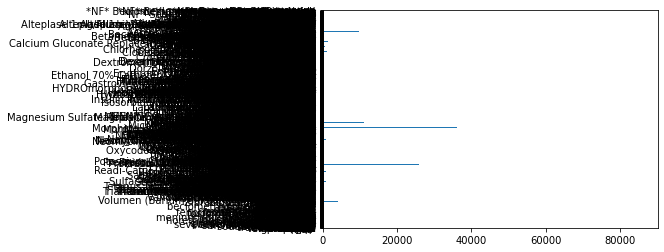

In [17]:
drugPlot.plot(kind='barh')

In [48]:
del drugPlot

### Top 10 Drugs

In [46]:
top100Drugs = drugPlot.iloc[:100]

In [47]:
for drug in top100Drugs.iloc[:10].items():
    print(drug)

('Furosemide', 85851)
('Insulin', 84420)
('Potassium Chloride', 63168)
('Metoprolol', 51486)
('Acetaminophen', 47726)
('Metoprolol Tartrate', 42252)
('Morphine Sulfate', 36029)
('Lorazepam', 34193)
('Heparin', 29433)
('Docusate Sodium', 27590)


### Admissions

In [27]:
admissions = pd.read_csv(os.path.join(DATA, 'ADMISSIONS.csv.gz'))

In [34]:
# subject_id,hadm_id
admissions = admissions[['SUBJECT_ID', 'HADM_ID']]
admissions

,SUBJECT_ID,HADM_ID
0,22,165315
1,23,152223
2,23,124321
3,24,161859
4,25,129635
...,...,...
58971,98800,191113
58972,98802,101071
58973,98805,122631
58974,98813,170407


## Data Preprocessing

In [54]:
def remove_multiple_admissions(df):
    """
    Removes hospital admissions that occur more than once for the same patient
  
    Parameters:
    df (DataFrame): Takes in dataframe with multiple hospital admissions
  
    Returns:
    Dataframe: Returns dataframe with multiple hospital admissions removed
    """
    first_admissions = admissions
    first_admissions = first_admissions.drop_duplicates(subset=['SUBJECT_ID'], keep='first')
    df = df[df['HADM_ID'].isin(first_admissions['HADM_ID'])]
    return df

In [102]:
lab_measurements = labValues

In [104]:
top100_drugs = pd.DataFrame(top100Drugs, columns=['DRUG']).reset_index()
top100_drugs.rename(columns = {'index':'DRUG', 'DRUG':'COUNT'}, inplace = True)
top100_drugs

,DRUG,COUNT
0,Furosemide,85851
1,Insulin,84420
2,Potassium Chloride,63168
3,Metoprolol,51486
4,Acetaminophen,47726
...,...,...
95,Clopidogrel Bisulfate,2956
96,Omeprazole,2862
97,traZODONE,2735
98,HydrALAZINE HCl,2708


In [103]:
patient_presc = prescriptions

In [106]:
patient_presc = remove_multiple_admissions(patient_presc)
patient_presc = patient_presc[patient_presc['DRUG'].isin(top100_drugs['DRUG'])]

In [108]:
patient_presc['STARTDATE'] += datetime.timedelta(hours=12)
patient_presc

,SUBJECT_ID,HADM_ID,STARTDATE,DRUG,DOSE_VAL_RX,FORMULARY_DRUG_CD,DOSE_UNIT_RX
30,13,143045,2167-01-10 12:00:00,Midazolam HCl,2,MIDA2I,mg
32,13,143045,2167-01-10 12:00:00,Lorazepam,1,LORA2I,mg
33,13,143045,2167-01-10 12:00:00,Magnesium Sulfate,2,MAGS1I,gm
34,13,143045,2167-01-10 12:00:00,Potassium Chloride,40,MICROK10,mEq
35,13,143045,2167-01-10 12:00:00,Ketorolac,15,KETO15I,mg
...,...,...,...,...,...,...,...
4156445,98887,121032,2144-09-07 12:00:00,PredniSONE,40,PRED20,mg
4156446,98887,121032,2144-09-07 12:00:00,Ipratropium Bromide Neb,1,IPRA2H,NEB
4156447,98887,121032,2144-09-07 12:00:00,HYDROmorphone (Dilaudid),0.12,HYDR20/100NS,mg
4156448,98887,121032,2144-09-07 12:00:00,Docusate Sodium,100,DOCU100,mg


In [109]:
lab_measurements = lab_measurements[lab_measurements.duplicated(subset=['SUBJECT_ID','LABEL'],keep=False)]
lab_measurements = lab_measurements[lab_measurements['HADM_ID'].isin(patient_presc['HADM_ID'])]

## Generating Lab Test<>Drug Pairings

In [111]:
def labpairing(drugname, prescdf, labdf, labname):
    """Pairs the drug input with each lab test

    Parameters:
    drugname (String): Drug Name
    prescdf (DataFrame): Dataframe containing the prescription data
    labdf (DataFrame): Dataframe containing the lab measurement data
    labname (DataFrame): Lab Test Name
    Returns:
    DataFrame: Contains all the rows of values and times for that particular drug lab apir
  
    """
    # Select patients who have taken the drug
    prescdf = prescdf[prescdf['DRUG']==drugname]
    prescdf = prescdf.drop_duplicates(subset=['SUBJECT_ID'], keep='first')

    # Select lab measurements of patients who have taken the drug
    labdf = labdf[labdf['HADM_ID'].isin(prescdf['HADM_ID'])]

    # Selects the lab measurement entered
    drug_lab_specific = labdf[labdf['LABEL']==labname]
    mergeddf = pd.merge(drug_lab_specific, prescdf, on=['HADM_ID','SUBJECT_ID'])

    # Get time from prescription and choose before and after lab measurements (within 24hrs=1day)
    mergeddf['timeFromPrescription'] = mergeddf['CHARTTIME'] - mergeddf['STARTDATE']
    mergeddf = mergeddf[(mergeddf['timeFromPrescription']>datetime.timedelta(days=-1)) & (mergeddf['timeFromPrescription']<datetime.timedelta(days=1))]
    posmergeddf = mergeddf.loc[mergeddf.timeFromPrescription > datetime.timedelta(days=0)]
    negmergeddf = mergeddf.loc[mergeddf.timeFromPrescription < datetime.timedelta(days=0)]
    
    # Only keep values for which we have both before and after
    posmergeddf = posmergeddf[posmergeddf['HADM_ID'].isin(negmergeddf['HADM_ID'])]
    negmergeddf = negmergeddf[negmergeddf['HADM_ID'].isin(posmergeddf['HADM_ID'])]

    #Select the values closest to 0
    posmergeddf = posmergeddf.loc[posmergeddf.groupby('SUBJECT_ID').timeFromPrescription.idxmin()]
    negmergeddf = negmergeddf.loc[negmergeddf.groupby('SUBJECT_ID').timeFromPrescription.idxmax()]
    finaldf = negmergeddf.merge(posmergeddf,on=['HADM_ID','SUBJECT_ID'])
    
    return finaldf

## Performing Mannwhitney Test and T-Test

In [117]:
def postprocessing(df):
    """Gets the mean, standard deviation, mann whitney and t-test p values. Converts time delta to hours
  
    Parameters:
    df (DataFrame): Dataframe containing before and after lab test values and time values
    Returns:
    List:Containing mean, standard deviation, mann whitney and t-test p values and count
  
    """
    df['timeFromPrescription_x'] = pd.to_numeric(df['timeFromPrescription_x'].dt.seconds)
    df['timeFromPrescription_x']/=3600
    df['timeFromPrescription_y'] = pd.to_numeric(df['timeFromPrescription_y'].dt.seconds)
    df['timeFromPrescription_y']/=3600
    df_before_mean = df['VALUENUM_x'].mean()
    df_after_mean = df['VALUENUM_y'].mean()
    df_before_std = df['VALUENUM_x'].std()
    df_after_std = df['VALUENUM_y'].std()
    df_before_time_mean = df['timeFromPrescription_x'].mean()
    df_after_time_mean = df['timeFromPrescription_y'].mean()
    df_before_time_std = df['timeFromPrescription_x'].std()
    df_after_time_std = df['timeFromPrescription_y'].std()
    mannwhitneypvalue = mannwhitneyu(df['VALUENUM_x'], df['VALUENUM_y'])[1]
    ttestpvalue = stats.ttest_ind(df['VALUENUM_x'], df['VALUENUM_y'])[1]
    lengthofdf = len(df)
    csvrow=[lengthofdf,df_before_mean,df_before_std,df_before_time_mean,df_before_time_std,df_after_mean,df_after_std,df_after_time_mean,df_after_time_std,mannwhitneypvalue,ttestpvalue]
    return csvrow

 

In [115]:
drug_lab = labpairing('Furosemide', patient_presc, lab_measurements, 'Calcium, Total')

## Final Results

In [ ]:
def comp_analysis(lab_measurements, top100_drugs, n_druglab_pairs = 25):
    res = pd.DataFrame(columns=['Medication Name','Feature Name','Number of patients','Feature Before(mean)','Feature Before(std)','Time Before(mean)','Time Before(std)','Feature After(mean)','Feature After(std)','Time After(mean)','Time After(std)','Mannwhitney-pvalue','Ttest-pvalue'])
    uniqueLabTests = lab_measurements.LABEL.unique()

    for i, drug in enumerate(top100_drugs['DRUG']): 
        print(i, ' Drug: ', drug)
        for j in tqdm(range(uniqueLabTests.shape[0])):
            labTest = uniqueLabTests[j]
            drug_lab=labpairing(drug, patient_presc, lab_measurements, labTest)
            if(len(drug_lab) > n_druglab_pairs): 
                csvrow=postprocessing(drug_lab)
                csvrow.insert(0, i) 
                csvrow.insert(1, labTest)
                res.loc[len(res)] = csvrow
    return res
# Potassium Chloride Alanine Aminotransferase (ALT)
# Insulin Alanine Aminotransferase (ALT)

In [ ]:
n_druglab_pairs = 25
res = pd.DataFrame(columns=['Medication Name','Feature Name','Number of patients','Feature Before(mean)','Feature Before(std)','Time Before(mean)','Time Before(std)','Feature After(mean)','Feature After(std)','Time After(mean)','Time After(std)','Mannwhitney-pvalue','Ttest-pvalue'])
uniqueLabTests = lab_measurements.LABEL.unique()

for i, drug in enumerate(top100_drugs['DRUG']): 
    print(i, ' Drug: ', drug)
    for j in tqdm(range(uniqueLabTests.shape[0])):
        labTest = uniqueLabTests[j]
        drug_lab=labpairing(drug, patient_presc, lab_measurements, labTest)
        if(len(drug_lab) > n_druglab_pairs): 
            csvrow=postprocessing(drug_lab)
            csvrow.insert(0, i) 
            csvrow.insert(1, labTest)
            res.loc[len(res)] = csvrow

# Potassium Chloride Alanine Aminotransferase (ALT)
# Insulin Alanine Aminotransferase (ALT)

0  Drug:  Furosemide


 17%|█▋        | 32/192 [00:34<02:07,  1.25it/s]

In [127]:
csvdf

,Medication Name,Feature Name,Number of patients,Feature Before(mean),Feature Before(std),Time Before(mean),Time Before(std),Feature After(mean),Feature After(std),Time After(mean),Time After(std),Mannwhitney-pvalue,Ttest-pvalue
0,Furosemide,"Calcium, Total",3689,7.865194,0.596117,15.318731,3.130199,7.895690,0.767306,12.782805,5.543262,4.869298e-04,0.056653
1,Insulin,"Calcium, Total",4723,7.805293,0.586089,15.372041,3.264240,7.849037,0.591139,12.703472,5.666672,1.005113e-07,0.000306
2,Potassium Chloride,"Calcium, Total",3051,7.837234,0.517342,15.812040,3.026666,7.878663,0.519142,13.507331,5.619706,1.045076e-05,0.001803
3,Metoprolol,"Calcium, Total",2076,7.865896,0.564997,15.530210,3.122839,7.880250,0.555806,13.623627,5.225266,9.761628e-02,0.409290
4,Acetaminophen,"Calcium, Total",3972,7.787941,0.561434,15.379435,3.287844,7.839300,0.563105,13.225097,5.562219,2.322292e-10,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,Sodium Bicarbonate,PTT,413,55.798063,25.284375,16.674899,4.949476,54.140436,24.302883,8.983535,6.175378,4.808567e-02,0.337058
1626,Phytonadione,PTT,580,51.215069,21.058976,16.234310,4.000901,52.952241,25.770537,10.717529,6.350503,3.275688e-01,0.208976
1627,Neostigmine,PTT,229,46.417031,16.257331,11.809389,7.175490,45.053275,21.336951,11.478384,5.472444,7.425724e-06,0.442089
1628,Ipratropium Bromide MDI,PTT,405,58.165185,25.123963,16.967490,3.866947,56.378272,23.154625,9.598848,6.053865,2.276299e-01,0.292876


In [126]:
csvdf.to_csv(os.path.join(PARENT, 'Drug-Labtest_1630_Pairs.csv'))